# Kaggle Starter Code for House of Blocks Kaggle In-Class Competition

This workbook is a starter code for the [Kaggle In-Class House of Blocks Competition](https://www.kaggle.com/c/applications-of-deep-learning-wustl-fall-2020)  This competition is one of the assignments for [T81-558: Applications of Deep Neural Netw1orks](https://sites.wustl.edu/jeffheaton/t81-558/) at [Washington University in St. Louis](https://www.wustl.edu).

This notebook is not a particularly high-scoring model; however, it does demonstrate how to begin the project entirely in Kaggle.  It is also possable to run this project from Google CoLab.  I have a separate starter project for CoLab.  

In [1]:
import numpy as np
import pandas as pd
import os

PATH = "/kaggle/input/applications-of-deep-learning-wustl-fall-2020/final-kaggle-data/"
PATH_TRAIN = os.path.join(PATH, "train.csv")
PATH_TEST = os.path.join(PATH, "test.csv")

In [2]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

df_train = df_train[df_train.id != 1300]

df_train['filename'] = df_train["id"].astype(str)+".png"
df_train['stable'] = df_train['stable'].astype(str)

df_test['filename'] = df_test["id"].astype(str)+".png"

In [3]:
TRAIN_PCT = 0.8
TRAIN_CUT = int(len(df_train) * TRAIN_PCT)

df_train_cut = df_train[0:TRAIN_CUT]
df_validate_cut = df_train[TRAIN_CUT:]

print(f"Training size: {len(df_train_cut)}")
print(f"Validate size: {len(df_validate_cut)}")

Training size: 32784
Validate size: 8197


In [4]:
import PIL
import os
from PIL import Image
from PIL import ImageFilter

# image = Image.open("../input/applications-of-deep-learning-wustl-fall-2020/final-kaggle-data/10.png")
# image = image.filter(ImageFilter.SHARPEN).filter(ImageFilter.SHARPEN)
# image = image.convert('L')
# image

Image_PATH = "../input/applications-of-deep-learning-wustl-fall-2020/final-kaggle-data"
for image in os.listdir(Image_PATH):
    try:
        f_img = Image_PATH+"/"+image
        image = Image.open(f_img)
        image = image.filter(ImageFilter.SHARPEN)
        image = image.filter(ImageFilter.SHARPEN)
        #image = image.convert('L')
    except:
        print("something is wrong")
        pass

something is wrong
something is wrong
something is wrong
something is wrong


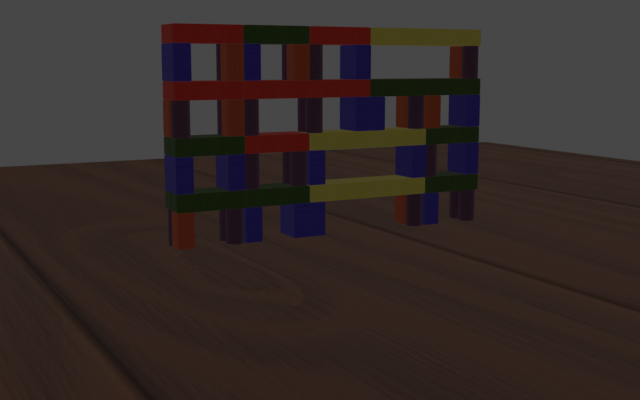

In [8]:
# image = Image.open("../input/applications-of-deep-learning-wustl-fall-2020/final-kaggle-data/95.png")
# image

In [9]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

WIDTH = 640
HEIGHT = 400
training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
#   featurewise_center = True,
#   zca_epsilon = 0.001,
#   zca_whitening = True,
#   zoom_range = [0.7,0.8],
  brightness_range = [1.0,1.2],
  #Original set it to True, I will set False
  vertical_flip = False,
  fill_mode='nearest')

train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train_cut,
        directory=PATH,
        x_col="filename",
        y_col="stable",
        target_size=(HEIGHT, WIDTH),
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale = 1./255,
#                                           featurewise_center = True,
#                                           zca_epsilon = 0.001,
#                                           zca_whitening = True,
#                                           zoom_range = [0.7,0.8],
                                          brightness_range = [1.0,1.3])

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate_cut,
        directory=PATH,
        x_col="filename",
        y_col="stable",
        target_size=(HEIGHT, WIDTH),
        class_mode='binary')

Found 32784 validated image filenames belonging to 2 classes.
Found 8197 validated image filenames belonging to 2 classes.


In [10]:
## Learning Rate Schedule
def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 20:
        lr = 0.00001
    elif epoch > 15:
        lr = 0.00005
    elif epoch > 10:
        lr = 0.00008
    elif epoch > 5:
        lr = 0.0001
    print('Learning rate: ', lr)
    return lr
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)

We now create the neural network and fit it.  Some essential concepts are going on here.

* **Batch Size** - The number of training samples that should be evaluated per training step.  Smaller batch sizes, or mini-batches, are generally preferred.
* **Step** - A training step is one complete run over the batch.  At the end of a step, the weights are updated, and the neural network learns.
* **Epoch** - An arbitrary point at which to measure results or checkpoint the model.  Generally, an epoch is one complete pass over the training set.  However, when generators are used, the training set size is theoretically infinite. Because of this, we set a **steps_per_epoch** parameter.
* **validation steps** - The validation set may also be infinite; because of this, we must specify how many steps we wish to validate at the end of each Epoch.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.applications import *
from keras.models import Model
import keras

base_model = tf.keras.applications.Xception(input_shape=(HEIGHT,WIDTH, 3), include_top=False)
base_model.trainable = True

# base_model = ResNet50(include_top=False, input_shape=(HEIGHT,WIDTH, 3))
# base_model.trainable = True

# base_model = EfficientNetB1(include_top=False,input_shape=(HEIGHT,WIDTH, 3))
# base_model.trainable = True 


model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 13, 20, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [12]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)
callback_list = [monitor, lr_callback]


model.compile(loss = 'binary_crossentropy', optimizer='adam')

history = model.fit(train_generator,  
  verbose = 1, 
  validation_data=val_generator, 
  steps_per_epoch=250, 
  validation_steps=10,
  callbacks=callback_list, epochs=25)

Learning rate:  0.0001

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/25
250/250 [==============================] - 305s 1s/step - loss: 0.6772 - val_loss: 0.6254
Learning rate:  0.0001

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/25
250/250 [==============================] - 303s 1s/step - loss: 0.5706 - val_loss: 0.5355
Learning rate:  0.0001

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 3/25
250/250 [==============================] - 303s 1s/step - loss: 0.2828 - val_loss: 0.2241
Learning rate:  0.0001

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 4/25
250/250 [==============================] - 303s 1s/step - loss: 0.1034 - val_loss: 0.0406
Learning rate:  0.0001

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 5/25
250/250 [==============================] - 303s 1s/step - loss: 0.0615 - val_loss: 0.0448
Learning rate:  0.0001

Epoch 

In [15]:
model.save("./Xception_Oct_7.h5")

In [16]:
from IPython.display import FileLink
FileLink(r'Xception_Oct_7.h5')

/kaggle/working/Xception_Oct_7.h5

# Build Submission

Now that the neural network is trained; we need to generate a submit CSV file to send to Kaggle.  We will use nearly the same technique to build the submit file.  However, these essential points that we must address:

* We do not want the data generator to create an infinite date like we did when training.  We have a fixed number of cases to score for the Kaggle submit; we only want to process them.
* We do not want the data generator to randomize the samples' order like it did when training. Therefore we set shuffle to false.
* We want to always start at the beginning of the data, so we reset the generator.

These ensure that the predictions align with the id's.

In [17]:
submit_datagen = ImageDataGenerator(rescale = 1./255)

submit_generator = submit_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="filename",
        batch_size = 1,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode=None)

submit_generator.reset()
pred = model.predict(submit_generator,steps=len(df_test))

Found 10294 validated image filenames.


In [20]:
df_submit = pd.DataFrame({"id":df_test['id'],'stable':pred.flatten()})
df_submit.to_csv("./submit.csv",index = False)

In [21]:
from IPython.display import FileLink
FileLink(r'submit.csv')

/kaggle/working/submit.csv

In [26]:
from keras.models import Sequential, load_model
model_tune = load_model("Xception_Oct_7.h5")

monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)

history = model_tune.fit(train_generator,  
  verbose = 1, 
  validation_data=val_generator, 
  steps_per_epoch=250, 
  validation_steps=10,
  epochs=20)

Epoch 1/20
500/500 [==============================] - 693s 1s/step - loss: 0.0078 - val_loss: 0.0197
Epoch 2/20
500/500 [==============================] - 691s 1s/step - loss: 0.0082 - val_loss: 0.0124
Epoch 3/20
500/500 [==============================] - 690s 1s/step - loss: 0.0044 - val_loss: 0.0092
Epoch 4/20
500/500 [==============================] - 687s 1s/step - loss: 0.0037 - val_loss: 0.0059
Epoch 5/20
500/500 [==============================] - 685s 1s/step - loss: 0.0038 - val_loss: 0.0090
Epoch 6/20
500/500 [==============================] - 688s 1s/step - loss: 0.0049 - val_loss: 0.0046
Epoch 7/20
500/500 [==============================] - 684s 1s/step - loss: 0.0045 - val_loss: 0.0056
Epoch 8/20
500/500 [==============================] - 689s 1s/step - loss: 0.0037 - val_loss: 0.0075
Epoch 9/20
500/500 [==============================] - 687s 1s/step - loss: 0.0016 - val_loss: 0.0107
Epoch 10/20
500/500 [==============================] - 686s 1s/step - loss: 0.0028 - val_lo

In [27]:
model_tune.save("./Xception_Tune_Oct_7.h5")
from IPython.display import FileLink
FileLink(r'Xception_Tune_Oct_7.h5')

/kaggle/working/Xception_Tune_Oct_7.h5

In [28]:
submit_datagen = ImageDataGenerator(rescale = 1./255,brightness_range = [1.0,1.2])

submit_generator = submit_datagen.flow_from_dataframe(
        dataframe=df_test,
        directory=PATH,
        x_col="filename",
        batch_size = 1,
        shuffle = False,
        target_size=(HEIGHT, WIDTH),
        class_mode=None)

submit_generator.reset()
pred = model.predict(submit_generator,steps=len(df_test))
df_submit = pd.DataFrame({"id":df_test['id'],'stable':pred.flatten()})
df_submit.to_csv("./submit2.csv",index = False)
FileLink(r'submit2.csv')

Found 10294 validated image filenames.


/kaggle/working/submit2.csv

### Further Fine Tune with Brighter Images

In [1]:
training_datagen = ImageDataGenerator(
  rescale = 1./255,
  horizontal_flip=True,
#   featurewise_center = True,
#   zca_epsilon = 0.001,
#   zca_whitening = True,
#   zoom_range = [0.7,0.8],
  brightness_range = [0.9,1.6],
  #Original set it to True, I will set False
  vertical_flip = False,
  fill_mode='nearest')

train_generator = training_datagen.flow_from_dataframe(
        dataframe=df_train_cut,
        directory=PATH,
        x_col="filename",
        y_col="stable",
        target_size=(HEIGHT, WIDTH),
        batch_size=16,
        class_mode='binary')

validation_datagen = ImageDataGenerator(rescale = 1./255,
#                                           featurewise_center = True,
#                                           zca_epsilon = 0.001,
#                                           zca_whitening = True,
#                                           zoom_range = [0.7,0.8],
                                          brightness_range = [1.2,1.5])

val_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_validate_cut,
        directory=PATH,
        x_col="filename",
        y_col="stable",
        target_size=(HEIGHT, WIDTH),
        class_mode='binary')

from keras.models import load_model
model_tune_2 = load_model("Xception_Tune_Oct_7.h5")

def lr_schedule2(epoch):
    lr = 0.00005
    if epoch > 10:
        lr = 0.00001
    return lr

lr_callback2 = tf.keras.callbacks.LearningRateScheduler(lr_schedule2, verbose=True)
monitor2 = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=1, mode='auto',
        restore_best_weights=True)
callback_list2 = [monitor2, lr_callback2]


history = model_tune.fit(train_generator,  
  verbose = 1, 
  validation_data=val_generator, 
  steps_per_epoch=500, 
  validation_steps=100,
  epochs=20,callbacks=callback_list2)

NameError: name 'ImageDataGenerator' is not defined